# Faiss Tutorial

## 라이브러리

In [1]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

## Dataset (SIFT1M, GIST1M)

### 다운로드
다운로드 링크: http://corpus-texmex.irisa.fr

ex.
다운 받은 파일: sift.tar.gz

In [3]:
!tar -zxvf sift.tar.gz

sift/
sift/sift_base.fvecs
sift/sift_groundtruth.ivecs
sift/sift_learn.fvecs
sift/sift_query.fvecs


### 파일 불러오기

In [2]:
def read_fvecs(filename):
    with open(filename, 'rb') as f:
        # 읽기
        data = np.fromfile(f, dtype='int32')
        # 첫 번째 값을 차원으로 사용
        dim = data[0]
        # 데이터 변환 및 리턴
        return data.reshape(-1, dim + 1)[:, 1:].astype('float32')

In [3]:
def read_ivecs(filename):
    with open(filename, 'rb') as f:
        # 읽기
        data = np.fromfile(f, dtype='int32')
        # 첫 번째 값을 차원으로 사용
        dim = data[0]
        # 데이터 변환 및 리턴
        return data.reshape(-1, dim + 1)[:, 1:]

In [4]:
# 파일 경로 설정

## sift1m
base_path = 'sift/sift_base.fvecs'
learn_path = 'sift/sift_learn.fvecs'
query_path = 'sift/sift_query.fvecs'
groundtruth_path = 'sift/sift_groundtruth.ivecs'

## gist1m
# base_path = 'gist/gist_base.fvecs'
# learn_path = 'gist/gist_learn.fvecs'
# query_path = 'gist/gist_query.fvecs'
# groundtruth_path = 'gist/gist_groundtruth.ivecs'

In [5]:
# 파일 읽기
base = read_fvecs(base_path)
learn = read_fvecs(learn_path)
query = read_fvecs(query_path)
groundtruth = read_ivecs(groundtruth_path)

In [6]:
# sift
print(f'Base shape: {base.shape}')
print(f'Learn shape: {learn.shape}')
print(f'Query shape: {query.shape}')
print(f'Groundtruth shape: {groundtruth.shape}')

Base shape: (1000000, 128)
Learn shape: (100000, 128)
Query shape: (10000, 128)
Groundtruth shape: (10000, 100)


## Indexing

In [7]:
# 차원 수
dim = base.shape[1]

# FlatL2 인덱스 생성 및 학습
index_flat = faiss.IndexFlatL2(dim)
index_flat.add(base)

# IVF 인덱스 생성 및 학습
nlist = 200  # Number of clusters
quantizer = faiss.IndexFlatL2(dim)
index_ivf = faiss.IndexIVFFlat(quantizer, dim, nlist)
index_ivf.train(learn)
index_ivf.add(base)

# HNSW 인덱스 생성 및 학습
index_hnsw = faiss.IndexHNSWFlat(dim, 16)
index_hnsw.add(base)

# PQ 인덱스 생성 및 학습
index_pq = faiss.IndexPQ(dim, 2, 8)
index_pq.train(learn)
index_pq.add(base)

# LSH 인덱스 생성 및 학습
index_lsh = faiss.IndexLSH(dim, 2)
index_lsh.train(learn)
index_lsh.add(base)

## Search 성능 평가

In [8]:
def search_and_measure(index, queries, groundtruth, k=5):
    start_time = time.time()
    distances, indices = index.search(queries, k)
    query_time = time.time() - start_time
    
    recall = []
    for i, neighbors in enumerate(indices):
        gt = set(groundtruth[i][:k])
        retrieved = set(neighbors)
        correct = len(gt & retrieved)
        recall.append(correct / k)
    
    avg_recall = np.mean(recall)
    avg_query_time = query_time / len(queries)
    
    return avg_recall, avg_query_time

In [14]:
# IVF의 nprobe 값 변경에 따른 성능 측정
nprobe_values = [1, 2, 5, 10, 20, 50, 100, 200]
ivf_results = []

for nprobe in tqdm(nprobe_values):
    index_ivf.nprobe = nprobe
    recall, query_time = search_and_measure(index_ivf, query, groundtruth, k=5)
    ivf_results.append((recall, query_time))

100%|█████████████████████████████████████████████| 8/8 [09:17<00:00, 69.72s/it]


In [15]:
# HNSW의 efSearch 값 변경에 따른 성능 측정
efSearch_values = [10, 20, 50, 100, 200, 500, 1000, 2000]
hnsw_results = []

for efSearch in tqdm(efSearch_values):
    index_hnsw.hnsw.efSearch = efSearch
    recall, query_time = search_and_measure(index_hnsw, query, groundtruth, k=5)
    hnsw_results.append((recall, query_time))

100%|█████████████████████████████████████████████| 8/8 [00:22<00:00,  2.80s/it]


In [11]:
# PQ의 M 값 변경에 따른 성능 측정
M_values = [1, 2, 4, 8, 16, 32, 64, 128] # sift dataset
# M_values = [40, 48, 60, 64, 80, 96, 120, 160] # gist dataset
pq_results = []

for M in tqdm(M_values):
    index_pq = faiss.IndexPQ(dim, M, 8)
    index_pq.train(learn)
    index_pq.add(base)
    recall, query_time = search_and_measure(index_pq, query, groundtruth, k=5)
    pq_results.append((recall, query_time))

100%|█████████████████████████████████████████████| 8/8 [06:19<00:00, 47.42s/it]


In [12]:
# LSH의 hash_bit_count 값 변경에 따른 성능 측정
hash_bit_count_values = [1, 2, 4, 8, 16, 32, 64, 65] # sift dataset
# hash_bit_count_values = [2, 4, 8, 16, 32, 64, 128, 256] # gist dataset
lsh_results = []

for hash_bit_count in tqdm(hash_bit_count_values):
    index_lsh = faiss.IndexLSH(dim, hash_bit_count * dim)
    index_lsh.train(learn)
    index_lsh.add(base)
    recall, query_time = search_and_measure(index_lsh, query, groundtruth, k=5)
    lsh_results.append((recall, query_time))

100%|█████████████████████████████████████████████| 8/8 [13:10<00:00, 98.81s/it]


## 시각화

### SIFT

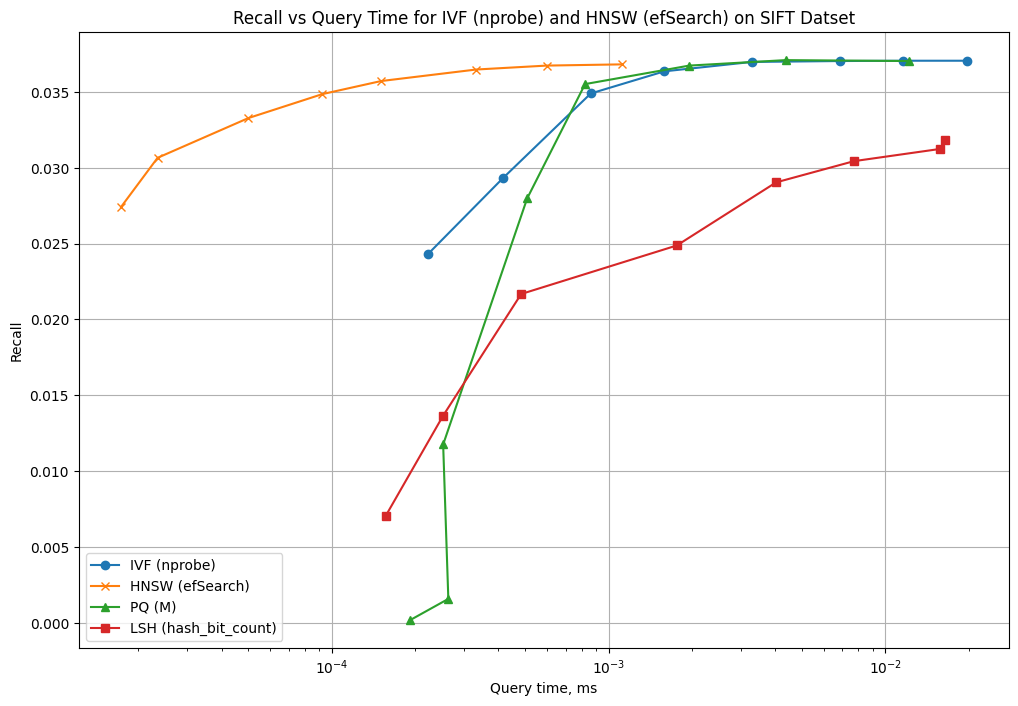

In [13]:
# Recall 및 Query Time 시각화
plt.figure(figsize=(12, 8))

# IVF 결과 시각화
ivf_recall_values = [result[0] for result in ivf_results]
ivf_query_time_values = [result[1] for result in ivf_results]
plt.plot(ivf_query_time_values, ivf_recall_values, label='IVF (nprobe)', marker='o')

# HNSW 결과 시각화
hnsw_recall_values = [result[0] for result in hnsw_results]
hnsw_query_time_values = [result[1] for result in hnsw_results]
plt.plot(hnsw_query_time_values, hnsw_recall_values, label='HNSW (efSearch)', marker='x')

# PQ 결과 시각화
pq_recall_values = [result[0] for result in pq_results]
pq_query_time_values = [result[1] for result in pq_results]
plt.plot(pq_query_time_values, pq_recall_values, label='PQ (M)', marker='^')

# LSH 결과 시각화
lsh_recall_values = [result[0] for result in lsh_results]
lsh_query_time_values = [result[1] for result in lsh_results]
plt.plot(lsh_query_time_values, lsh_recall_values, label='LSH (hash_bit_count)', marker='s')

plt.xscale('log')
plt.xlabel('Query time, ms')
plt.ylabel('Recall')
plt.title('Recall vs Query Time for IVF (nprobe) and HNSW (efSearch) on SIFT Datset')
plt.legend()
plt.grid(True)
plt.savefig('figure/SIFT1M.png', format='png')
plt.show()

### GIST

In [ ]:
# Recall 및 Query Time 시각화
plt.figure(figsize=(12, 8))

# IVF 결과 시각화
ivf_recall_values = [result[0] for result in ivf_results]
ivf_query_time_values = [result[1] for result in ivf_results]
plt.plot(ivf_query_time_values, ivf_recall_values, label='IVF (nprobe)', marker='o')

# HNSW 결과 시각화
hnsw_recall_values = [result[0] for result in hnsw_results]
hnsw_query_time_values = [result[1] for result in hnsw_results]
plt.plot(hnsw_query_time_values, hnsw_recall_values, label='HNSW (efSearch)', marker='x')

# PQ 결과 시각화
pq_recall_values = [result[0] for result in pq_results]
pq_query_time_values = [result[1] for result in pq_results]
plt.plot(pq_query_time_values, pq_recall_values, label='PQ (M)', marker='^')

# LSH 결과 시각화
lsh_recall_values = [result[0] for result in lsh_results]
lsh_query_time_values = [result[1] for result in lsh_results]
plt.plot(lsh_query_time_values, lsh_recall_values, label='LSH (hash_bit_count)', marker='s')

plt.xscale('log')
plt.xlabel('Query time, ms')
plt.ylabel('Recall')
plt.title('Recall vs Query Time for IVF (nprobe) and HNSW (efSearch) on SIFT Datset')
plt.legend()
plt.grid(True)
plt.savefig('figure/SIFT1M.png', format='png')
plt.show()